## Configuration for Colab

## Import modules

In [ ]:
import copy
import random
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

In [ ]:
! pip install gymnasium
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import cvxpy as cp
import numpy as np
import cmath
from gymnasium import spaces
from gym.spaces import Discrete, Box

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 3.6 MB/s eta 0:00:00


## Set random seed

In [ ]:
x_min = 0
x_max = 5
y_min = 0
y_max = 5
z_min = 0
z_max = 5
deltax = x_max - x_min; deltay = y_max - y_min; deltaz = z_max - z_min
N = 64
c = 3e8
f = 2.4e9
Nf = 1
lambda_wg = c/f
DMA_WG_dist = lambda_wg/2
DMA_element_dist = lambda_wg/2

d_app1 = 20e-3
d_app2 = 30e-3
d_app3 = 50e-3
d_start = d_app3
max_Ptx = 10
P_o = 10e-6

DMA_loc = np.array([(x_min + x_max)/2 - (math.sqrt(N)/2)*DMA_element_dist, (y_min + y_max)/2 - (math.sqrt(N)/2)*DMA_WG_dist, z_max]);


DMA_element_loc = np.zeros((int(math.sqrt(N)*math.sqrt(N)), 3))

for i in range(0, int(math.sqrt(N))):
    for j in range(0, int(math.sqrt(N))):
        DMA_element_loc[(i)*int(math.sqrt(N)) + j, :] = np.array([DMA_loc[0] + (j)*DMA_element_dist,
            DMA_loc[1] + (i)*DMA_WG_dist, DMA_loc[2]])

DMA_element_loc1 = DMA_element_loc
DMA_element_loc = np.reshape(DMA_element_loc, (int(math.sqrt(N)), int(math.sqrt(N)), 3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.605551275463989
3.605551275463989
3.605551275463989
3.605551275463989


(0.0, 5.0)

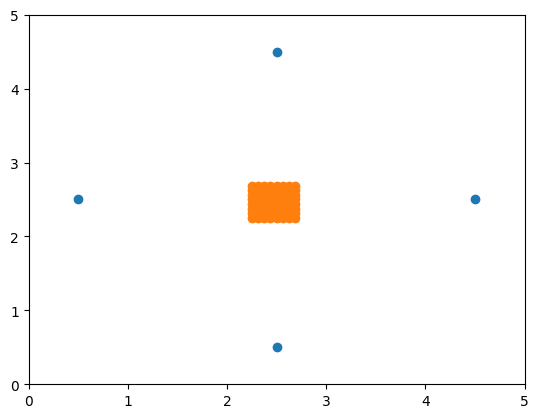

In [ ]:
M = 4
rdist = 2
user_locs = np.zeros((M, 3))
for k in range(M):
  user_locs[k, :] = np.array([x_max/2 + rdist*np.cos(2*k*np.pi/M), x_max/2 + rdist*np.sin(2*k*np.pi/M), 2])
  print(np.linalg.norm(user_locs[k, :] - np.array([x_max/2, x_max/2 ,z_max])))

plt.scatter(user_locs[:, 0], user_locs[:, 1])
plt.scatter(DMA_element_loc1[:, 0], DMA_element_loc1[:, 1])
plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)

In [ ]:
boresight_gain = 2
D = (math.sqrt(N)-1)*0.5*lambda_wg; frensel = ((D**4)/(8*lambda_wg))**(1/3); fraunhofer = (2*(D**2))/lambda_wg
ELV_vec = np.zeros((int(math.sqrt(N)), int(math.sqrt(N)), M))
AZM_vec = np.zeros((int(math.sqrt(N)), int(math.sqrt(N)), M))
field_vec_DMA = np.zeros((1, M)); # 1 nearfield 0 farfield 2 nothing
distance_vec = np.zeros((1, M))

for i in range(int(math.sqrt(N))):
    for j in range (int(math.sqrt(N))):
        for m in range(M):
            d3D  = math.sqrt(np.sum((np.reshape(DMA_element_loc[i, j, :], (1, 3)) - user_locs[m, :])**2))
            if d3D > fraunhofer:
                field_vec_DMA[0, m] = 1
            elif d3D < fraunhofer and d3D > frensel:
                field_vec_DMA[0, m]= 0
            else:
                field_vec_DMA[0, m] = 2
            distance_vec[0, m] = d3D
            dz = np.linalg.norm(DMA_element_loc[i, j, 2] - user_locs[m, 2])
            dy = np.linalg.norm(DMA_element_loc[i, j, 1] - user_locs[m, 1])
            dx = np.linalg.norm(DMA_element_loc[i, j, 0] - user_locs[m, 0])
            dxy = math.sqrt(np.sum((np.reshape(DMA_element_loc[i, j, 0:2], (1, 2)) - user_locs[m, 0:2])**2))
            ELV_vec[i, j, m] = math.asin(dxy/d3D); AZM_vec[i, j, m] = math.acos(dx/dxy)

channel_vec_DMA = np.zeros((int(math.sqrt(N)), int(math.sqrt(N)), Nf, M), dtype=np.complex64)

for i in range(int(math.sqrt(N))):
    for l in range (int(math.sqrt(N))):
        for n in range(Nf):
            for m in range(M):
                d3D  = np.linalg.norm(np.reshape(DMA_element_loc[i, l, :], (1, 3)) - user_locs[m, :])
                dz = np.linalg.norm(DMA_element_loc[i, l, 2] - user_locs[m, 2])
                channel_rad = 2*(boresight_gain+1)*((dz/d3D)**boresight_gain)
                lambda_wg_temp = c/f
                A_channel = math.sqrt(channel_rad)*(lambda_wg_temp/(4*math.pi*d3D))
                phase_channel = d3D/lambda_wg_temp
                channel_vec_DMA[i, l, n, m] = A_channel*np.exp(complex(0, -2*math.pi*phase_channel))

a_chan = np.reshape(channel_vec_DMA, (N, M))

In [ ]:
print(i,l,n,m)
print(channel_rad,A_channel, d3D, dz, phase_channel,channel_vec_DMA[2, 2, 0, 0])

7 7 0 1
4.961952620244077 0.006716698933814869 3.298910805099162 3.0 26.391286440793294 (0.0074142516-0.00093625946j)


In [ ]:
lower_bound = [0 for k in range(M + 1)]
upper_bound = [1 for k in range(M + 1)]
upper_bound[-1] = 1
lower_bound[-1] = 0

In [ ]:
aj = 105
bj = 0.003
Mj = 20e-3

class WC_Env(gym.Env):

    def __init__(self, N, M):
        self.max_buffer = 4*d_app3 + P_o
        self.M = M  # The User Number
        self.observation_space = Box(low=np.array([0 for k in range(M)]), high=np.array([self.max_buffer for k in range(M)]), dtype=np.float32)
        self.outage_prob = 0
        self.state_space = Box(low=np.array([0 for k in range(M)]), high=np.array([self.max_buffer for k in range(M)]), dtype=np.float32)


        self.action_space =  spaces.Box(low=np.array(lower_bound),
                               high=np.array(upper_bound),
                               dtype=np.float32)


    def step(self, action, req_data):
      alpha_vec_temp = [round(action[k], 1) for k in range(M)]
      if np.sum(alpha_vec_temp) != 0:
        alpha_vec = [alpha_vec_temp[k]/np.sum(alpha_vec_temp) for k in range(M)]
      else:
        alpha_vec = alpha_vec_temp
      # alpha_vec = action[0:-1]
      # print(alpha_vec)
      # alpha_vec = action[0:-1]
      tx_power = action[-1]*max_Ptx
      w_beam = np.ones((N, M), dtype=np.complex128)/1000
      fval = 800
      fval0 = 1000
      lambd = 1
      if np.sum(alpha_vec) == 0 or tx_power == 0:
        observation = [0 for k in range(M)]
      else:
        mybetavec = 0.0001*np.ones((M, 1))
        mymuvec = 0.0001*np.ones((M, 1))
        w_beam = np.ones((N, M))/10000;
        P_rvec = np.zeros((M, 1))
        for k in range(M):
            for m in range(M):
                P_rvec[k] += (np.linalg.norm(a_chan[:, k].transpose().conj()@ w_beam[:, m]))**2
        lambd = 1
        phivec = np.zeros((2*M, 1))
        for k in range(M):
            phivec[k] = mybetavec[k] * (1 + np.exp(-aj*(P_rvec[k] - bj))) - Mj
            phivec[M + k] = mymuvec[k] * (1 + np.exp(-aj*(P_rvec[k] - bj))) - 1
        lambd_vec = np.zeros((M, 1))
        for k in range(M):
            lambd_vec[k] = alpha_vec[k] * mybetavec[k] * aj * mymuvec[k] * np.exp(-aj * (P_rvec[k] - bj))
        coefcons = 0.5
        iter_outs = 5
        it_bf = 1;
        for it_out in range(iter_outs):
          w_beam = np.ones((N, M), 'complex128') / 10000
          lambd = 1
          fval = 800
          fval0 = 1000
          P_rvec = np.zeros((M, 1))
          for k in range(M):
              for m in range(M):
                  P_rvec[k] += (np.linalg.norm(a_chan[:, k].conj().transpose()@ w_beam[:, m])) ** 2

          lambd_vec = np.zeros((M, 1), 'complex128')
          for k in range(M):
              lambd_vec[k] = alpha_vec[k] * mybetavec[k] * aj * mymuvec[k] * np.exp(-aj * (P_rvec[k] - bj))

          it_bf = 1
          mugrad = 0.05
          while np.linalg.norm(fval - fval0) > 1e-6:
              w_beam0 = w_beam
              fval0 = fval
              for m in range(M):
                  cons = np.zeros((N, 1), 'complex128')
                  for k in range(M):
                      Ak = np.reshape(a_chan[:, k], (N, 1)) @ np.reshape(a_chan[:, k].conj().transpose(), (1, N))
                      cons += lambd_vec[k] * (Ak @ np.reshape(w_beam[:, m], (N, 1)))
                  w_beam[:, m] = (1 / lambd) * np.reshape(cons, N)
              w_beam = w_beam0 + mugrad*(w_beam - w_beam0)
              P_rvec = np.zeros((M, 1))
              for k in range(M):
                  for m in range(M):
                      P_rvec[k] += np.linalg.norm(np.dot(a_chan[:, k].conj().transpose(), w_beam[:, m])) ** 2

              for k in range(M):
                  lambd_vec[k] = -alpha_vec[k] * mymuvec[k] * mybetavec[k] * aj * np.exp(-aj * (P_rvec[k] - bj))

              cons2 = np.zeros((N, M), 'complex128')
              for m in range(M):
                  for k in range(M):
                      Ak = np.reshape(a_chan[:, k], (N, 1)) @ np.reshape(a_chan[:, k].conj().transpose(), (1, N))
                      cons2[:, m] += np.reshape(lambd_vec[k] * (Ak @ np.reshape(w_beam[:, m], (N, 1))), N)
              lambd = np.sqrt((1 / max_Ptx) * np.linalg.norm(cons2, 'fro') ** 2)

              objiter = 0
              for k in range(M):
                  objiter += alpha_vec[k] * mymuvec[k] * (Mj - mybetavec[k] * (1 + np.exp(-aj * (P_rvec[k] - bj))))
              fval = objiter
              it_bf += 1
              if it_bf > 10:
                  break

          phivec = np.zeros((2 * M, 1))
          for k in range(M):
              phivec[k] = mybetavec[k] * (1 + np.exp(-aj * (P_rvec[k] - bj))) - Mj
              phivec[M + k] = mymuvec[k] * (1 + np.exp(-aj * (P_rvec[k] - bj))) - 1

          if np.sum(np.abs(phivec) > 1e-4) == 0:
              break
          # print(it_out)
          # print(np.abs(phivec))
          jacobvec = np.eye(2 * M)
          for k in range(M):
              jacobvec[k, k] = 1 + np.exp(-aj * (P_rvec[k] - bj))
              jacobvec[M + k, M + k] = 1 + np.exp(-aj * (P_rvec[k] - bj))

          qvec = -np.linalg.inv(jacobvec) @ phivec
          coef = 0.5

          while True:
              tempmybetavec = mybetavec + coef * qvec[:M]
              tempmymuvec = mymuvec + coef * qvec[M:]
              tempphivec = np.zeros((2 * M, 1))
              for k in range(M):
                  tempphivec[k] = tempmybetavec[k] * (1 + np.exp(-aj * (P_rvec[k] - bj))) - Mj
                  tempphivec[M + k] = tempmymuvec[k] * (1 + np.exp(-aj * (P_rvec[k] - bj))) - 1
              if np.linalg.norm(tempphivec) <= (1 - coef * coefcons) * np.linalg.norm(phivec):
                  break
              else:
                  coef *= coef

          mymuvec += coef * qvec[M:]
          mybetavec += coef * qvec[:M]

        P_rvec = np.zeros((M, 1))
        for k in range(M):
            for m in range(M):
                P_rvec[k] += np.linalg.norm(np.dot(a_chan[:, k].conj().transpose(), w_beam[:, m])) ** 2
        first_term = Mj / (1 + np.exp(-aj * (P_rvec - bj)))
        phij = 1 / (1 + np.exp(aj * bj))
        P_dcvec_MY = (first_term - Mj * phij) / (1 - phij)
        observation = [P_dcvec_MY[k][0] for k in range(M)]


      notsatnum = 0
      terminated = None
      truncuated = False
      info  = None
      not_enough = 0
      for k in range(M):
          if self.state[k] < max(req_data[k], P_o):
            notsatnum += 1
            not_enough += max(req_data[k], P_o) - self.state[k]
          self.state[k] =  self.state[k] - max(req_data[k], P_o) if  self.state[k] >= max(req_data[k], P_o) else self.state[k]
          self.state[k] += observation[k]
          self.state[k] = min(self.state[k], self.max_buffer)
          # self.state[k + M] = req_data[k] + P_o

      self.outage_prob += notsatnum
      self.totalPtx += tx_power
      # reward = -(notsatnum)*(not_enough/self.max_buffer) + np.exp(-tx_power/max_Ptx)
      # reward = -2*np.exp(notsatnum/M) + np.exp(-tx_power/max_Ptx)
      # reward = -1000*not_enough + np.exp(-tx_power/max_Ptx)
      # reward = -(notsatnum/M) - (not_enough/self.max_buffer) - tx_power/max_Ptx
      reward = -np.exp(notsatnum + not_enough/self.max_buffer) - np.exp(tx_power/max_Ptx)
      # if notsatnum > 0:
      #   reward = -(notsatnum + 1000*not_enough)
      # else:
      #   reward = -tx_power/max_Ptx
      return self.state, reward, terminated

    def reset(self):
        self.state = [d_start for k in range(M)]
        # for k in range(M):
        #   self.state.append(P_o)
        # self.state += [0 for k in range(M)]
        self.outage_prob = 0
        self.totalPtx = 0
        return self.state

    def reset_pow(self):
        self.outage_prob = 0
        self.totalPtx = 0
        return self.state



In [ ]:
env = WC_Env(N, M)
env.reset()

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


[0.05, 0.05, 0.05, 0.05]

In [ ]:
state = env.reset()
env.state = [0,0, 0,0]
env.step([2, 1 ,0.3,1, 1], [0,0,0,0])
# print(env.totalPtx)

In [ ]:
print(np.sum(env.state*np.array([0.05, 0.1,1, 1, 1, 0.8])))

In [ ]:
num_actions = env.action_space.shape[0]
# Get the number of state observations
num_states = env.state_space.shape[0]
action_dim = num_actions
obs_dim = num_states

In [ ]:
print(num_states)

6


In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, action_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [ ]:
import torch.nn as nn

In [ ]:
class Actor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(num_states, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, num_actions)


    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).sigmoid()

        return action


class Critic(nn.Module):
    def __init__(
        self,
        in_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(num_states + num_actions, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [ ]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self,
        size: int,
        mu: float = 0.0,
        theta: float = 0.15,
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64([0.0 for k in range (M)])
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

In [ ]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.35, min_sigma=0.15, decay_period=100):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        # print(ou_state)
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [ ]:
class DDPGAgent:

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        actor_lr: float = 1e-4,
        critic_lr: float = 1e-4,
        EPS_START: float = 0.95,
        EPS_END: float = 0.05,
        EPS_DECAY: float = 10,
    ):
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.env = env
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_lr)
        # transition to store in memory
        self.transition = list()
        # total steps count
        self.total_step = 0
        # mode: train / test
        self.is_test = False
        self.noise = OUNoise(self.env.action_space, decay_period=self.EPS_DECAY)
        std_dev = 0.2
        self.payan = False


    def select_action_test(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""

        selected_action = self.actor(
            torch.FloatTensor(state).to(self.device)
        ).detach().cpu().numpy()

        return selected_action

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) *math.exp(-1. * self.total_step / self.EPS_DECAY)
        # add noise for exploration during training

        if np.random.random() <= eps_threshold and not self.payan:
          selected_action = self.env.action_space.sample()

        # print('state', state)
        self.transition = [state, selected_action]
        # print('action',selected_action)

        return selected_action

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        done = 0
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks

        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self._target_soft_update()

        return actor_loss.data, critic_loss.data

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        for self.total_step in range(1, num_frames + 1):
            # state = self.env.reset()
            episodic_reward = 0
            env.reset_pow()
            # env.reset()
            score = 0
            tt = 0
            while tt < total_T:
              req_data_gen = [traffic_dict[(m, self.total_step)][tt] for m in range(M)]
              action = self.select_action(state)
              action = self.noise.get_action(action, self.total_step)
              next_state, reward, done = self.env.step(action, req_data_gen)
              action_dict[(self.total_step, tt)] = action
              self.transition += [reward, next_state, done]
              self.memory.store(*self.transition)
              state = next_state
              score += reward
              tt += 1


              if (
                  len(self.memory) >= self.batch_size
                  and self.total_step > self.initial_random_steps and not self.payan
              ):
                  actor_loss, critic_loss = self.update_model()
                  actor_losses.append(actor_loss)
                  critic_losses.append(critic_loss)

              # plotting
            scores.append(score/total_T)
            if self.total_step > 25:
              episode_list_20avg.append(np.mean(scores[-20:]))
            else:
              episode_list_20avg.append(np.mean(scores))
            episode_list_avg.append(np.mean(scores))
            episode_list.append(score/total_T)
            episode_list_popt.append(env.totalPtx)
            episode_list_outage.append(env.outage_prob)
            print('Episode: ', self.total_step, 'Episode Score: ', score/total_T)
            print('Episode: ', self.total_step, ' Ptx_total: ', env.totalPtx, ' Outage_num: ', env.outage_prob)
            print('Episode: ', self.total_step, ' Final State: ', env.state)


    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau

        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

## Set random seed

In [ ]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

## Initialize

In [ ]:
total_T = 100

num_frames = 3000
application_dict = {}
application_dict[0] = d_app1 # compute
P1 = 0.3
lam_scale1 = 3
application_dict[1] = d_app2 # sense
P2 = 0.5
lam_scale2 = 2
application_dict[2] = d_app3 # emergency alert
P3 = 0.2
lam_scale3 = 1

rat1 = 10
rate_act = 1/rat1
rate_deact = 1 - 1/rat1
num_app = 3


prob_dict = {}

# for act in range (2):
#   for app_num in range(3):
#     prob_dict[(act, app_num)] =
burst_prob = 0.5
max_burst = 4
base_burst = 10e-3

global traffic_dict
traffic_dict = {}
for k in range(M):
  for fr in range(num_frames):
    traffic_dict[(k, fr)] = [0 for m in range(total_T)]

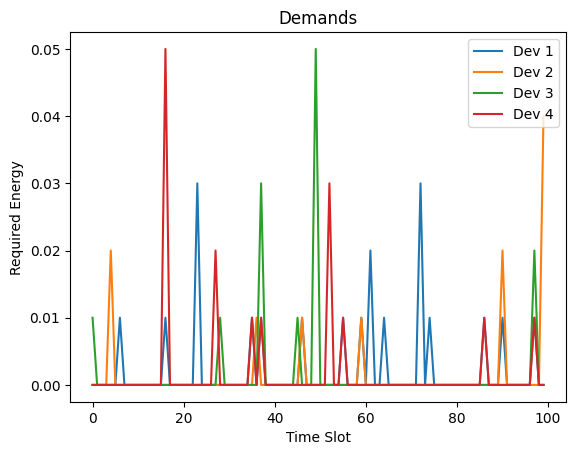

In [ ]:
plt.figure(1)
plt.title('Demands')
plt.xlabel('Time Slot')
plt.ylabel('Required Energy')
plt.plot(np.arange(total_T), traffic_dict[(0, 52)])
plt.plot(np.arange(total_T), traffic_dict[(1, 52)])
plt.plot(np.arange(total_T), traffic_dict[(2, 52)])
plt.plot(np.arange(total_T), traffic_dict[(3, 52)])
plt.legend(['Dev 1', 'Dev 2', 'Dev 3', 'Dev 4', 'Dev 5', 'Dev 6'])
plt.show()

In [ ]:
global action_dict
action_dict = {}
global episode_list
episode_list = []
global episode_list_avg
episode_list_avg = []
global episode_list_20avg
episode_list_20avg = []
global episode_list_outage
episode_list_outage = []
global episode_list_popt
episode_list_popt = []

# parameters
memory_size = 10000
batch_size = 64
num_frames = 1500
ou_noise_theta = 0.15
ou_noise_sigma = 0.2
initial_random_steps = 0
actor_lr = 1e-4
critic_lr = 2e-4
tau = 0.001
gamma = 0.99
env = WC_Env(N, M)
env.reset()
agent = DDPGAgent(
    env,
    memory_size,
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps,
    actor_lr = actor_lr,
    critic_lr = critic_lr,
    tau = tau,
    gamma = gamma,
    EPS_START= 0.0,
    EPS_END= 0.0,
    EPS_DECAY= 50
)

## Train

In [ ]:
agent.memory.obs_buf[4]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
agent.train(num_frames)

<ipython-input-24-09d2ea7a4711>:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jacobvec[k, k] = 1 + np.exp(-aj * (P_rvec[k] - bj))


Episode:  1 Episode Score:  -3.0407822876023363
Episode:  1  Ptx_total:  602.5449059588057  Outage_num:  2
Episode:  1  Final State:  [0.1720514319226044, 0.06694970744199341, 0.18155299499575245, 0.20001000000000002]
Episode:  2 Episode Score:  -2.40292941769132
Episode:  2  Ptx_total:  287.20672789861135  Outage_num:  0
Episode:  2  Final State:  [0.1999649585024562, 0.13562888207654425, 0.1543181443065117, 0.19086225511965965]
Episode:  3 Episode Score:  -2.9988232774345303
Episode:  3  Ptx_total:  623.4029776009878  Outage_num:  0
Episode:  3  Final State:  [0.15376835908451686, 0.19085241592915247, 0.19232599995697092, 0.19242003539462038]
Episode:  4 Episode Score:  -2.4883011666265475
Episode:  4  Ptx_total:  330.75767641567995  Outage_num:  0
Episode:  4  Final State:  [0.18229894122553278, 0.16973567385746627, 0.13085865191960794, 0.14276610286865485]
Episode:  5 Episode Score:  -2.51010161032024
Episode:  5  Ptx_total:  328.7736804745345  Outage_num:  1
Episode:  5  Final Sta

In [ ]:
plt.plot(episode_list, linewidth=1.5, color='black')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

In [ ]:
plt.plot(episode_list_20avg, linewidth=1.5, color='black')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

In [ ]:
plt.plot(episode_list_avg, linewidth=1.5, color='black')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

In [ ]:
episode_list_bench1 = []
episode_list_bench1_avg = []
episode_list_bench1_20avg = []
episode_list_popt_bench1 = []
episode_list_outage_bench1 = []
threshold_buf = 50e-3
env.reset()
test_episodes = 50
scores = []
test_start = len(episode_list)
for ep in range(test_start):
  episodic_reward = 0
  env.reset_pow()
  score = 0
  tt = 0
  while tt < total_T:
    req_data_gen = [traffic_dict[(m, ep)][tt] for m in range(M)]
    if tt < total_T - 1:
      req_data_gen_future = [traffic_dict[(m, ep)][tt + 1] for m in range(M)]
    else:
      req_data_gen_future = [traffic_dict[(m, ep + 1)][0] for m in range(M)]
    cur_state = env.state
    pred_state = [max(0, cur_state[k] - req_data_gen[k]) for k in range(M)]
    act_cur = [0 for k in range(M + 1)]
    need_guys = []
    need_guys_idx = []
    for k in range(M):
      if pred_state[k] < req_data_gen_future[k]:
        act_cur[k] = 1
        act_cur[M] = 1
        need_guys.append(req_data_gen_future[k] - pred_state[k])
        need_guys_idx.append(k)
    for k in range(len(need_guys_idx)):
      act_cur[need_guys_idx[k]] = need_guys[k]/np.sum(need_guys)
    next_state, reward, done = env.step(act_cur, req_data_gen)
    score += reward
    tt += 1

  scores.append(score/total_T)
  if ep > 25:
    episode_list_bench1_20avg.append(np.mean(scores[-20:]))
  else:
    episode_list_bench1_20avg.append(np.mean(scores))
  episode_list_bench1.append(score/total_T)
  episode_list_bench1_avg.append(np.mean(scores))
  episode_list_popt_bench1.append(env.totalPtx)
  episode_list_outage_bench1.append(env.outage_prob)

In [ ]:
episode_list_bench1 = []
episode_list_bench1_avg = []
episode_list_bench1_20avg = []
episode_list_popt_bench1 = []
episode_list_outage_bench1 = []
threshold_buf = 50e-3
env.reset()
test_episodes = 50
scores = []
test_start = len(episode_list)
for ep in range(test_start):
  print(ep)
  episodic_reward = 0
  env.reset_pow()
  score = 0
  tt = 0
  while tt < total_T:
    req_data_gen = [traffic_dict[(m, ep)][tt] for m in range(M)]
    cur_state = env.state
    act_cur = [0 for k in range(M + 1)]
    need_guys = []
    need_guys_idx = []
    for k in range(M):
      if cur_state[k] < threshold_buf:
        act_cur[k] = 1
        act_cur[M] = 1
        need_guys.append(cur_state[k])
        need_guys_idx.append(k)
    for k in range(len(need_guys_idx)):
      act_cur[need_guys_idx[k]] = need_guys[k]/np.sum(need_guys)
    next_state, reward, done = env.step(act_cur, req_data_gen)
    score += reward
    tt += 1

  scores.append(score/total_T)
  if ep > 25:
    episode_list_bench1_20avg.append(np.mean(scores[-20:]))
  else:
    episode_list_bench1_20avg.append(np.mean(scores))
  episode_list_bench1.append(score/total_T)
  episode_list_bench1_avg.append(np.mean(scores))
  episode_list_popt_bench1.append(env.totalPtx)
  episode_list_outage_bench1.append(env.outage_prob)

In [ ]:
mov_avg = 50
episode_list_avg = []
episode_list_popt_bench1_avg = []
episode_list_outage_bench1_avg = []
for kk in range(len(episode_list_outage_bench1)):
  if kk < 25:

    episode_list_outage_bench1_avg.append(np.mean(episode_list_outage_bench1[:kk + 1]))
  else:

    episode_list_outage_bench1_avg.append(np.mean(episode_list_outage_bench1[:kk + 1]))
  if kk < 25:
    episode_list_popt_bench1_avg.append(np.mean(episode_list_popt_bench1[:kk + 1]))
  else:
    episode_list_popt_bench1_avg.append(np.mean(episode_list_popt_bench1[:kk + 1]))

episode_list_popt_avg = []
episode_list_outage_avg = []
for kk in range(len(episode_list_outage)):
  if kk < mov_avg:
    episode_list_avg.append(np.mean(episode_list[:kk + 1]))
    episode_list_outage_avg.append(np.mean(episode_list_outage[:kk + 1]))
  else:
    episode_list_avg.append(np.mean(episode_list[kk-mov_avg:kk + 1]))
    episode_list_outage_avg.append(np.mean(episode_list_outage[kk-mov_avg:kk + 1]))
  if kk < mov_avg:
    episode_list_popt_avg.append(np.mean(episode_list_popt[:kk + 1]))
  else:
    episode_list_popt_avg.append(np.mean(episode_list_popt[kk-mov_avg:kk + 1]))

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(((np.array(episode_list_avg))), linewidth=1, color='black')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(((np.array(episode_list_outage_avg))), linewidth=1, color='black')
plt.plot(((np.array(episode_list_outage_bench1_avg))), linewidth=1, color='red')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Outage Percentage", fontsize=12)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(((np.array(episode_list_popt_avg))), linewidth=1, color='black')
plt.plot(((np.array(episode_list_popt_bench1_avg))), linewidth=1, color='red')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Consumed Power", fontsize=12)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot((np.array(episode_list_outage)), linewidth=2.5, color='black')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Outage Percentage", fontsize=12)
plt.show()
plt.close()